# CIS 581 Final Project

## Imports

In [ ]:
import torch
import os
import numpy as np
import torchvision.models as models
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import requests
from io import BytesIO
import random
from IPython.display import display
import matplotlib.pyplot as plt
import cv2 as cv

## Download Pre-trained Models

In [18]:
vgg16 = models.vgg16(pretrained = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.eval()
vgg16_modules = list(vgg16.features.modules())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [35]:
vgg19 = models.vgg19(pretrained = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)
vgg19.eval()
vgg19_modules = list(vgg19.features.modules())

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
alex = models.alexnet(pretrained = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alex.to(device)
alex.eval()
alex_modules = list(alex.features.modules())

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
squeeze = models.squeezenet1_0(pretrained = True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
squeeze.to(device)
squeeze.eval()
squeeze_modules = list(squeeze.modules())

## Getting Images

In [ ]:
def get_image(url, max_dim=None):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    if (max_dim):
        image.thumbnail((max_dim, max_dim))              # .thumbnail preserves aspect ratio/always downsizes/always fits in max_dim x max_dim     
    return image

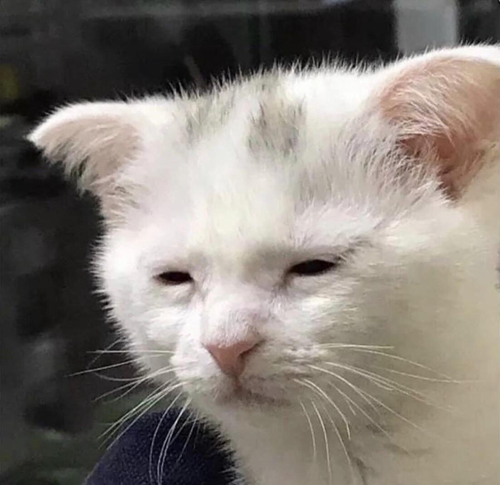

In [24]:
url = "https://i.redd.it/f67tf7ld9s431.jpg"
max_dim = 500
cat_img = get_image(url, max_dim)
display(cat_img)

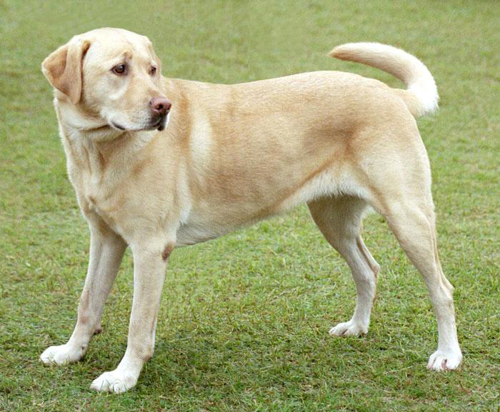

In [16]:
url = "https://www.tensorflow.org/tutorials/generative/deepdream_files/output_Y5BPgc8NNbG0_1.png"
max_dim = 500
dog_img = get_image(url, max_dim)
display(dog_img)

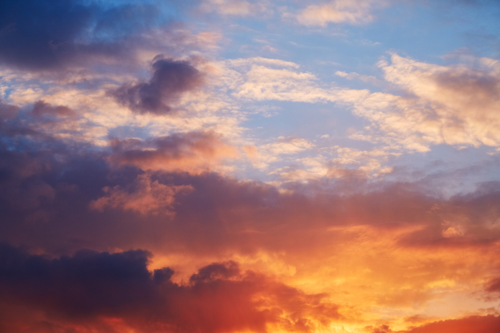

In [ ]:
url = "https://images.squarespace-cdn.com/content/v1/55cfb535e4b061baebe310df/1587472623697-IC8B3J3ZIZI0AMIE7U8G/ke17ZwdGBToddI8pDm48kLkXF2pIyv_F2eUT9F60jBl7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z4YTzHvnKhyp6Da-NYroOW3ZGjoBKy3azqku80C789l0iyqMbMesKd95J-X4EagrgU9L3Sa3U8cogeb0tjXbfawd0urKshkc5MgdBeJmALQKw/sky+photo+for+website+home+page.jpeg?format=2500w"
max_dim = 500
sky_img = get_image(url, max_dim)
display(sky_img)

## Normalization

In PyTorch, all pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

In [ ]:
normalize = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225]), # mean & stdev values from ImageNet
])

denormalize = transforms.Compose([
  transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]),
  transforms.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.]),
])

## Gradient Ascent

In [ ]:
def dream(image, model, modules, target_layer, lr, iterations):
  input = image.unsqueeze(0).to(device)
  input.requires_grad = True
  model.zero_grad()
  for i in range(iterations):
    temp = input
    for layer in range(target_layer):
      if hasattr(modules[layer + 1], 'in_channels') and modules[layer + 1].in_channels != temp.shape[1]:
        continue
      temp = modules[layer + 1](temp)
    loss = temp.norm()
    loss.backward()

    # Update the image by directly adding the gradients
    input.data = input.data + lr * (input.grad) #data is deprecated but detach() doesnt work?
  
  return input.squeeze()

## Basic DeepDream

VGG 16 Deepdream

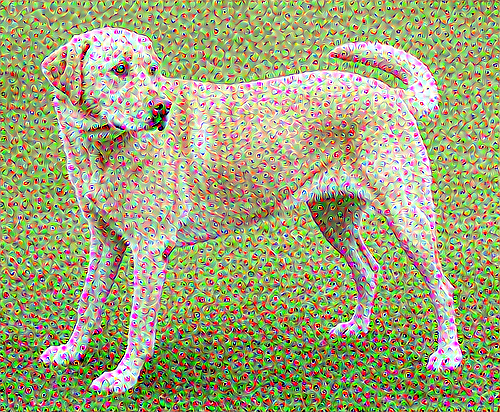

In [19]:
normalized_img = normalize(dog_img)
out = dream(normalized_img, vgg16, vgg16_modules, 10, 1e-2, 80)
img_out = out.detach().cpu()
denorm_img_out = denormalize(img_out)
img_out = denorm_img_out.permute(1, 2, 0)
img_out_np = img_out.numpy()
img_out_np = np.clip(img_out_np, 0, 1)
img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
display(img_out_pil)
img_out_pil.save('basic_deep_dream.png')

## Blend and Recursion

In [82]:
def deepdreamBlend(img, model, model_modules, target_layer, lr, EPOCH, OCTAVE_SCALE, filename, alpha): # assumes valid layer number
    orig_shape = np.array(img.size)
    float_orig_shape = orig_shape.astype(np.float32)
    img_res = None
    for n in range(-4, 2):
        new_shape = (float_orig_shape * (OCTAVE_SCALE**n)).astype(np.int32)
        img = img.resize(new_shape, Image.ANTIALIAS)
        normalized_img = normalize(img)
        out = dream(normalized_img, model, model_modules, target_layer, lr, EPOCH)
        img_out = out.detach().cpu()
        denorm_img_out = denormalize(img_out)
        img_out = denorm_img_out.permute(1, 2, 0)
        img_out_np = img_out.numpy()
        img_out_np = np.clip(img_out_np, 0, 1)
        img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))

        if (img_res):
            img_res2 = img_out_pil.resize(orig_shape, Image.ANTIALIAS)
            img_res = Image.blend(img_res, img_res2, alpha) # (0.6 - (n + 3)) if want to change relative to scale
        else:
            img_res = img_out_pil.resize(orig_shape, Image.ANTIALIAS)

    display(img_res)
    img_res.save(filename)

In [62]:
def deepdreamRecursive(img, model, model_modules, target_layer, lr, EPOCH, OCTAVE_SCALE, filename):
    init = img
    img = init
    
    orig_shape = np.array(init.size)
    float_orig_shape = orig_shape.astype(np.float32)

    for n in range(-4, 2):
      new_shape = (float_orig_shape * (OCTAVE_SCALE**n)).astype(np.int32)
      img = img.resize(new_shape, Image.ANTIALIAS)
      normalized_img = normalize(img)
      out = dream(normalized_img, model, model_modules, target_layer, lr, EPOCH)

      img_out = out.detach().cpu()
      denorm_img_out = denormalize(img_out)
      img_out = denorm_img_out.permute(1, 2, 0)
      img_out_np = img_out.numpy()
      img_out_np = np.clip(img_out_np, 0, 1)
      img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))

      img = img_out_pil.resize(orig_shape, Image.ANTIALIAS)
      display(img)

    img.save(filename)

In [80]:
def deepdreamBlendRecursive(img, model, model_modules, target_layer, lr, EPOCH, OCTAVE_SCALE, filename, alpha):
    init = img
    img = init
    
    orig_shape = np.array(init.size)
    float_orig_shape = orig_shape.astype(np.float32)

    img_res = None

    for n in range(-4, 2):
      new_shape = (float_orig_shape * (OCTAVE_SCALE**n)).astype(np.int32)
      img = img.resize(new_shape, Image.ANTIALIAS)
      normalized_img = normalize(img)
      out = dream(normalized_img, model, model_modules, target_layer, lr, EPOCH)

      img_out = out.detach().cpu()
      denorm_img_out = denormalize(img_out)
      img_out = denorm_img_out.permute(1, 2, 0)
      img_out_np = img_out.numpy()
      img_out_np = np.clip(img_out_np, 0, 1)
      img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))

      if (img_res):
        img_res2 = img_out_pil.resize(orig_shape, Image.ANTIALIAS)
        display(img_res2)
        img_res = Image.blend(img_res, img_res2, alpha)
      else:
        img_res = img_out_pil.resize(orig_shape, Image.ANTIALIAS)
      img = img_res

    display(img_res)

    img.save(filename)

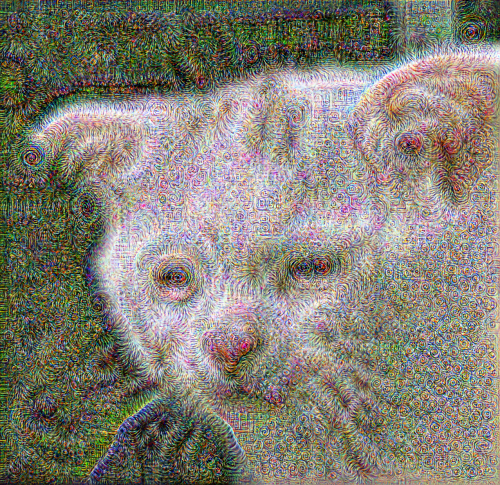

In [85]:
deepdreamBlend(cat_img, vgg16, vgg16_modules, 20, 1e-2, 50, 1.8, 'cat_img.jpg', 0.5)

In [42]:
deepdreamRecursive(cat_img, vgg16, vgg16_modules, 23, 1e-3, 100, 1.8, 'cat_img.jpg')

Output hidden; open in https://colab.research.google.com to view.

In [84]:
deepdreamBlendRecursive(cat_img, vgg19, vgg19_modules, 26, 3e-4, 100, 1.8, 'cat_img.jpg', 0.8)

Output hidden; open in https://colab.research.google.com to view.

## GIF

In [55]:
def transform_frame(frame):
  h, w = frame.shape[:2]
  deg = -2  # Adjust rotation speed (in [deg/frame])
  scale = 1.1  # Use this to (un)zoom while rotating around image center
  rotation_matrix = cv.getRotationMatrix2D((w / 2, h / 2), deg, scale)
  frame = cv.warpAffine(frame, rotation_matrix, (w, h))
  return frame

In [56]:
from os import path
def create_and_show_gif(filename):
  frames = []
  frame_0 = Image.open("/content/" + filename + "_" + "0.jpg")
  for i in range(50):
    if (path.exists("/content/" + filename + "_" + str(i+1) + ".jpg")):
      frames.append(Image.open("/content/" + filename + "_" + str(i+1) + ".jpg"))
  frame_0.save("/content/" + filename + ".gif", save_all=True, append_images=frames)
  result_gif = Image.open("/content/" + filename + ".gif")
  display(result_gif)

In [57]:
def save_frames(img, model, model_modules, target_layer, lr, EPOCH, OCTAVE_SCALE, filename):
  init = img
  img = init
  
  orig_shape = np.array(init.size)
  float_orig_shape = orig_shape.astype(np.float32)

  frame_id = 0

  for n in range(50):
    normalized_img = normalize(img)

    out = dream(normalized_img, model, model_modules, target_layer, lr, EPOCH)
    print(frame_id)

    img_out = out.detach().cpu()
    denorm_img_out = denormalize(img_out)
    img_out = denorm_img_out.permute(1, 2, 0)
    img_out_np = img_out.numpy()
    img_out_np = np.clip(img_out_np, 0, 1)
    transformed_frame = transform_frame(np.uint8(img_out_np * 255))
    img = Image.fromarray(transformed_frame)
    img.save("/content/" + filename + "_" + str(frame_id) + ".jpg")
    frame_id += 1

In [51]:
save_frames(cat_img, vgg16, vgg16_modules, 20, 2e-3, 40, 1.3, "cat_gif")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


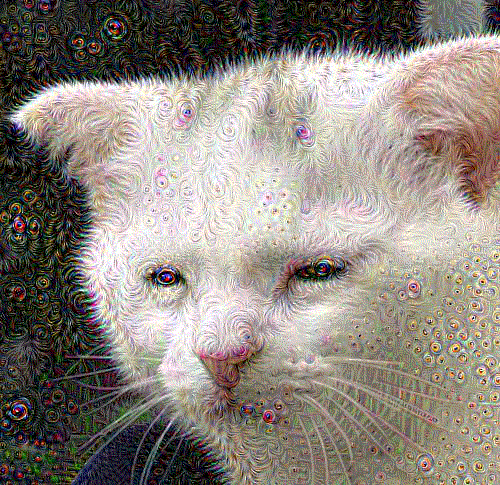

In [58]:
create_and_show_gif("cat_gif")